In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hull-tactical-market-prediction/train.csv
/kaggle/input/hull-tactical-market-prediction/test.csv
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_inference_server.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py
/kaggl

Loading data...
Loaded 10 test rows.
Loaded 9021 train rows.
Selected 94 numeric columns for features.
Engineering features for training...


Engineering Features: 100%|██████████| 94/94 [00:00<00:00, 187.71it/s]


Training lgbm on 1989 rows with 1222 features...
LGBM training completed.
Calculating In-Sample Score & Optimizing Parameters...
Optimization result: Optimization terminated successfully.
Best Score: 10.0548
Params: scale=3432.4234, bias=96.9130
Final In-Sample Volatility-Adjusted Sharpe: 10.0548

 >>> Starting Performance Visualization...
Initializing Feature Generator...
Setting up Inference Server...
Running local gateway on Kaggle (Interactive Mode)...
Processed 1 batches...
Processed 2 batches...
Processed 3 batches...
Processed 4 batches...
Processed 5 batches...
Success: submission.parquet generated.


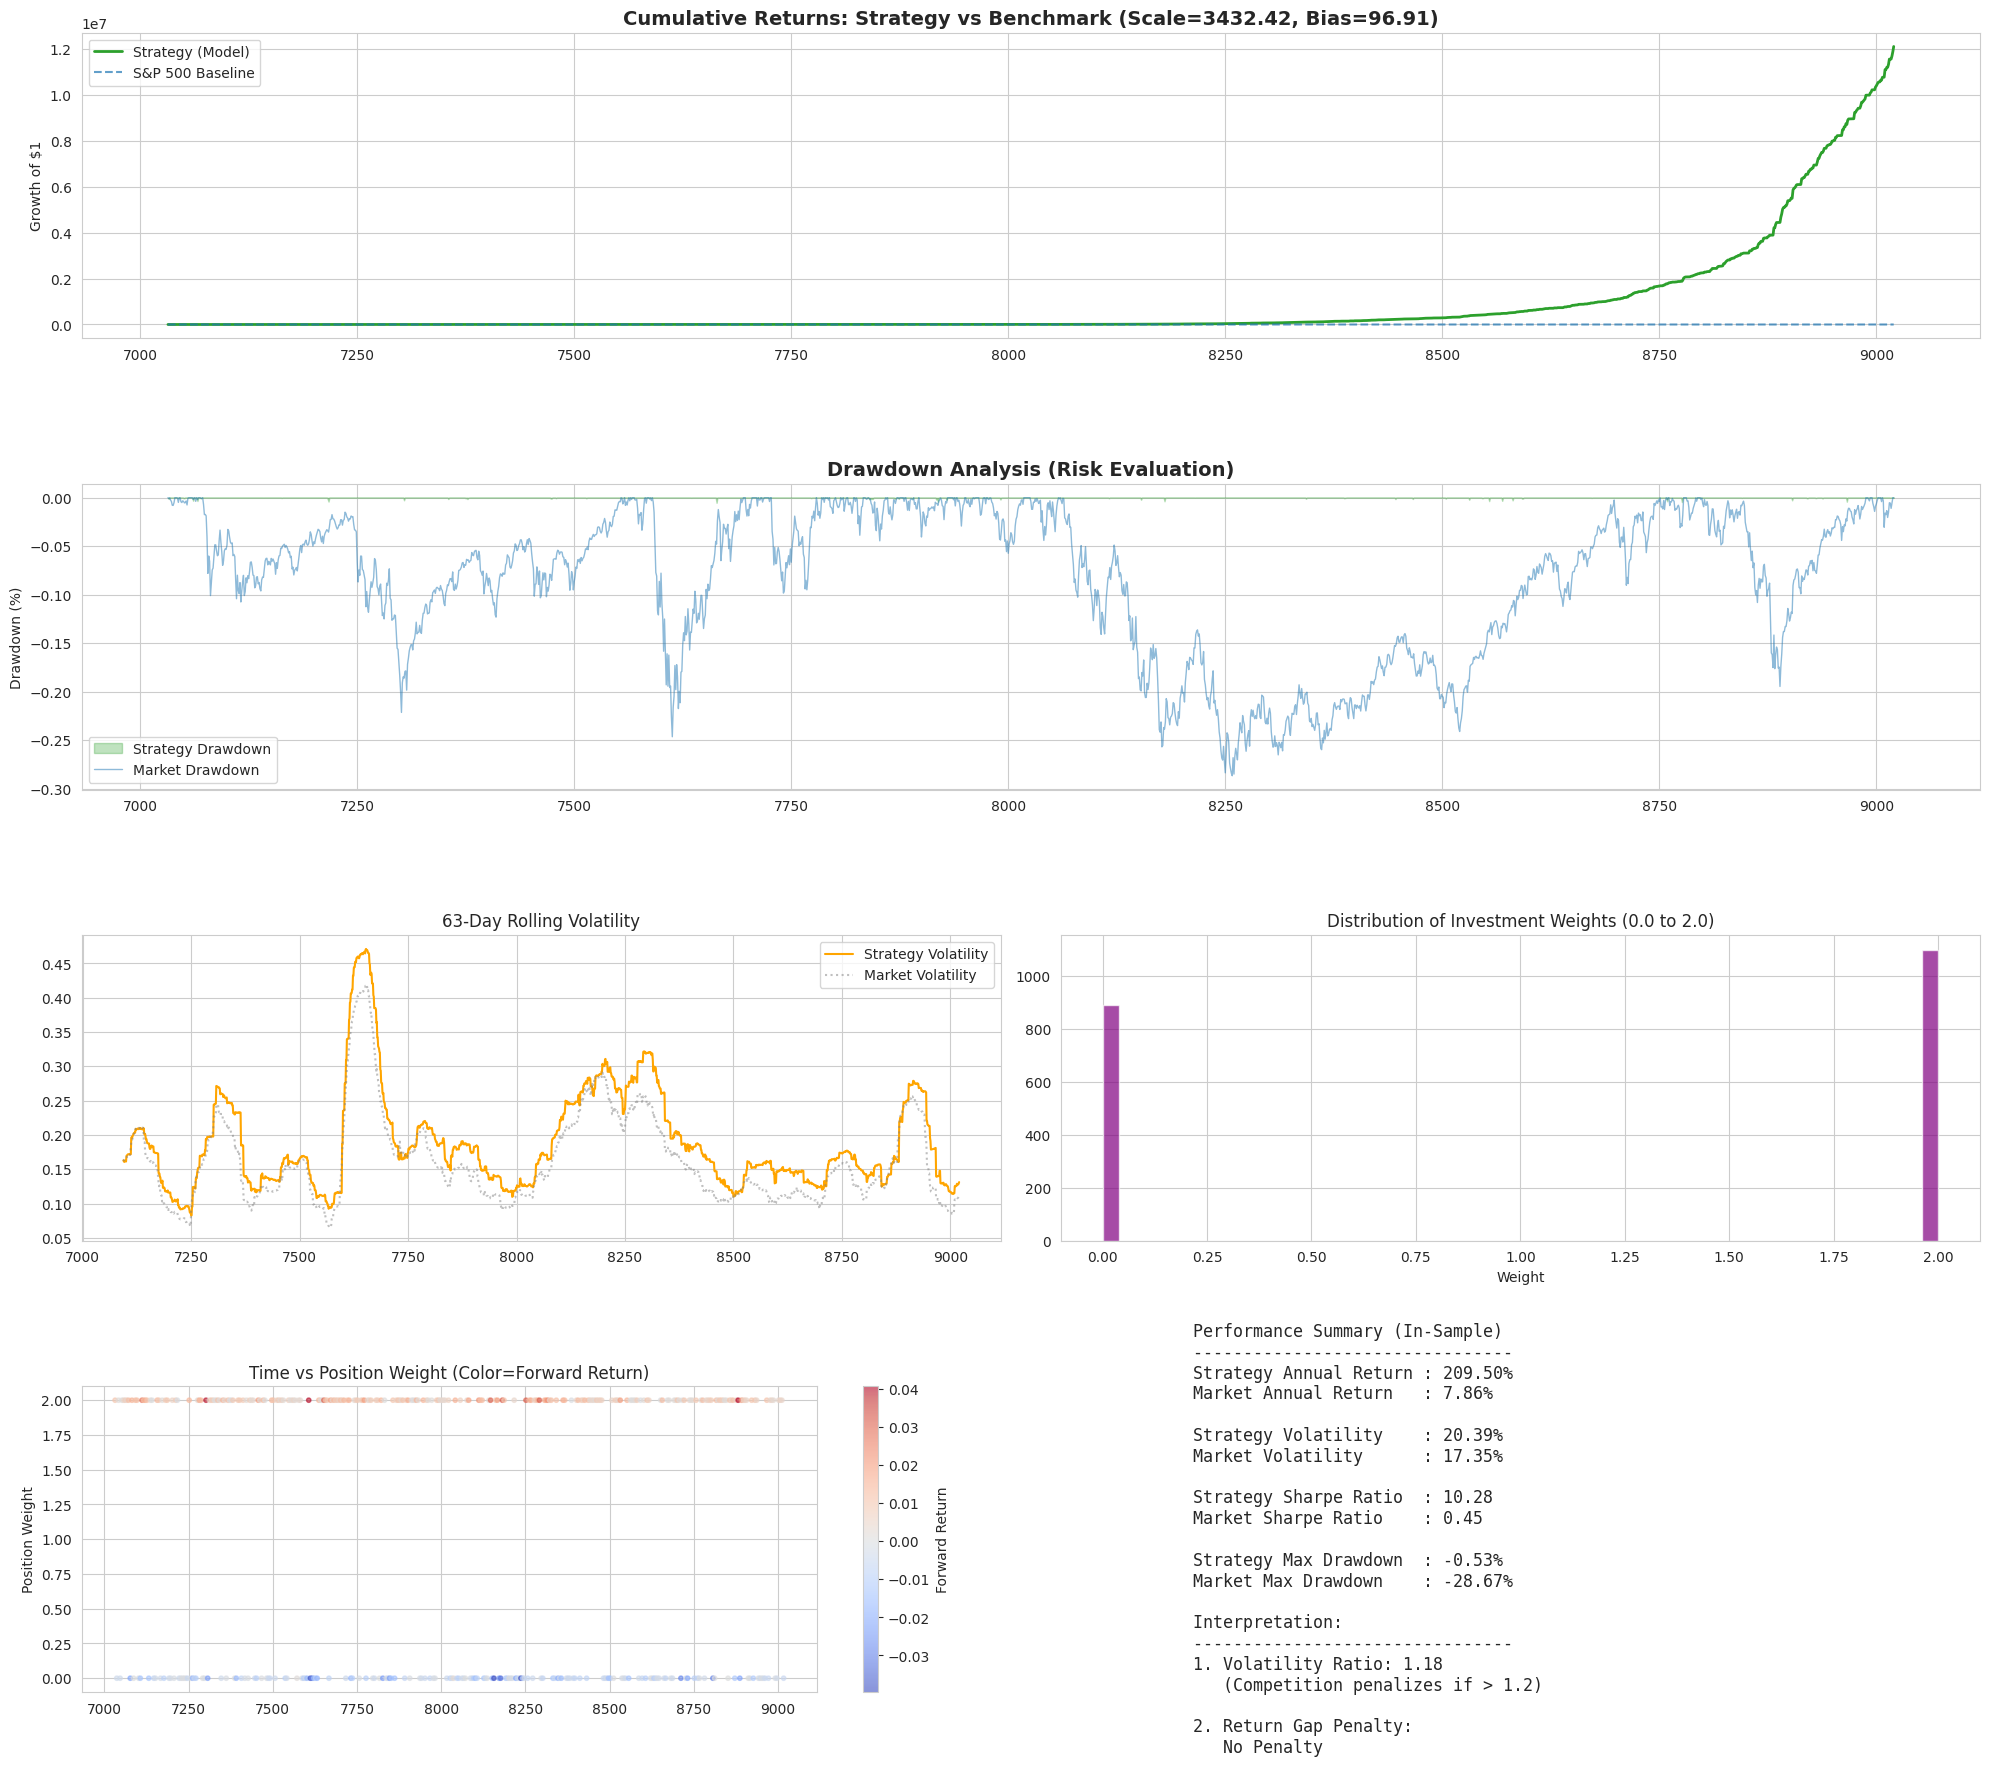

In [2]:
from __future__ import annotations

import os
import sys
from pathlib import Path
from typing import List, Tuple, Sequence

import numpy as np
import pandas as pd
import pandas.api.types
import polars as pl
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
from scipy.optimize import minimize

# --- Metric Implementation ---
MIN_INVESTMENT = 0
MAX_INVESTMENT = 2

class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Calculates a custom evaluation metric (volatility-adjusted Sharpe ratio).
    """
    if not pandas.api.types.is_numeric_dtype(submission['prediction']):
        raise ParticipantVisibleError('Predictions must be numeric')

    solution = solution.copy()
    solution['position'] = submission['prediction']

    if solution['position'].max() > MAX_INVESTMENT:
        print(f"Warning: Position max {solution['position'].max()} > {MAX_INVESTMENT}")
    if solution['position'].min() < MIN_INVESTMENT:
        print(f"Warning: Position min {solution['position'].min()} < {MIN_INVESTMENT}")

    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']

    # Calculate strategy's Sharpe ratio
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution)) - 1
    strategy_std = solution['strategy_returns'].std()

    trading_days_per_yr = 252
    if strategy_std == 0:
        return 0.0 
        
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate market return and volatility
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1
    market_std = solution['forward_returns'].std()

    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100)

    if market_volatility == 0:
        return 0.0

    # Calculate the volatility penalty
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    # Calculate the return penalty
    return_gap = max(
        0,
        (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
    )
    return_penalty = 1 + (return_gap**2) / 100

    # Adjust the Sharpe ratio by the volatility and return penalty
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return min(float(adjusted_sharpe), 1_000_000)

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False

# --- Configuration & Environment ---
IS_KAGGLE = Path('/kaggle').exists()

if IS_KAGGLE:
    INPUT_DIR = Path('/kaggle/input/hull-tactical-market-prediction')
    sys.path.append(str(INPUT_DIR))
else:
    INPUT_DIR = Path('.')
    sys.path.append(os.getcwd())

import kaggle_evaluation.default_inference_server

TRAIN_PATH = INPUT_DIR / 'train.csv'
TEST_PATH = INPUT_DIR / 'test.csv'

TARGET_COL = 'forward_returns'
DATE_COL = 'date_id'
BENCHMARK_COL = 'market_forward_excess_returns'

# --- 1. Data Loading & Feature Engineering ---

def load_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
    if not TRAIN_PATH.exists():
        print("Train file not found.")
        return pd.DataFrame(), pd.DataFrame()
        
    train_df = pd.read_csv(TRAIN_PATH).sort_values(DATE_COL).reset_index(drop=True)
    
    if TEST_PATH.exists():
        test_df = pd.read_csv(TEST_PATH).sort_values(DATE_COL).reset_index(drop=True)
        print(f"Loaded {len(test_df)} test rows.")
    else:
        test_df = pd.DataFrame()
        
    print(f"Loaded {len(train_df)} train rows.")
    return train_df, test_df

def engineer_features(df: pd.DataFrame, numeric_cols: Sequence[str], show_progress: bool = False) -> Tuple[pd.DataFrame, List[str]]:
    feats = df.copy()
    created_cols: List[str] = []
    new_features = []
    
    # Lags and Rolling stats
    LAG_WINDOWS = (1, 3, 5, 10, 21, 63)
    ROLL_WINDOWS = (5, 21, 63)
    
    iterator = tqdm(numeric_cols, desc="Engineering Features", disable=not show_progress)
    
    for col in iterator:
        if col not in feats.columns:
            continue
        if not pd.api.types.is_numeric_dtype(feats[col]):
            continue
            
        # Lags
        for lag in LAG_WINDOWS:
            lag_col = f'{col}_lag_{lag}'
            new_features.append(feats[col].shift(lag).rename(lag_col))
            created_cols.append(lag_col)
            
        # Rolling stats
        for window in ROLL_WINDOWS:
            roll_mean = f'{col}_roll_mean_{window}'
            roll_std = f'{col}_roll_std_{window}'
            
            # Calculate rolling stats
            rolling = feats[col].rolling(window)
            new_features.append(rolling.mean().shift(1).rename(roll_mean))
            new_features.append(rolling.std(ddof=0).shift(1).rename(roll_std))
            
            created_cols.extend([roll_mean, roll_std])
            
    if new_features:
        feats = pd.concat([feats] + new_features, axis=1)
        
    base_cols = [c for c in numeric_cols if c in feats.columns]
    feature_cols = base_cols + created_cols
    return feats, feature_cols

class FeatureGenerator:
    def __init__(self, numeric_cols: List[str]):
        self.numeric_cols = numeric_cols
        self.history = pd.DataFrame()
        
    def fit(self, df: pd.DataFrame):
        # Store last 100 rows to cover max rolling window (63) + buffer
        if not df.empty:
            self.history = df[self.numeric_cols].iloc[-100:].copy()
        
    def transform(self, new_df: pd.DataFrame) -> pd.DataFrame:
        # Append new data to history
        # Ensure we only keep relevant columns to save memory/time
        new_data_subset = new_df[self.numeric_cols]
        combined = pd.concat([self.history, new_data_subset], axis=0)
        
        # Calculate features on the combined window
        # We reuse the batch function
        feats, _ = engineer_features(combined, self.numeric_cols)
        
        # Extract features for the new rows only
        # The new rows are at the end
        new_feats = feats.iloc[-len(new_df):].copy()
        
        # Update history (keep last 100)
        self.history = combined.iloc[-100:]
        
        return new_feats

# --- 2. Model Development ---

def train_model(train_df: pd.DataFrame, feature_cols: List[str], model_type: str = 'lgbm'):
    X = train_df[feature_cols].fillna(0)
    y = train_df[TARGET_COL]
    
    print(f"Training {model_type} on {len(X)} rows with {len(feature_cols)} features...")
    
    if model_type == 'lgbm' and LIGHTGBM_AVAILABLE:
        model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, num_leaves=31, random_state=42, verbose=-1)
        model.fit(X, y)
        print("LGBM training completed.")
    else:
        # Fallback to RF
        model = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
        model.fit(X, y)
        print("RandomForest training completed.")
        
    return model

# --- 3. Global State & API ---

# Global variables for the API
model = None
feature_generator = None
feature_cols = []
target_mean = 0.0
target_std = 1.0
PREDICT_COUNTER = 0
# Optimization params
OPT_SCALE = 0.5
OPT_BIAS = 1.0

def predict(test: pl.DataFrame) -> float:
    """
    API Inference Function.
    Receives a batch of test data (Polars), returns a single float prediction.
    """
    global model, feature_generator, feature_cols, target_mean, target_std, PREDICT_COUNTER, OPT_SCALE, OPT_BIAS
    
    PREDICT_COUNTER += 1
    if PREDICT_COUNTER % 100 == 0 or PREDICT_COUNTER <= 5:
        print(f"Processed {PREDICT_COUNTER} batches...", flush=True)
    
    try:
        # Convert to Pandas
        test_df = test.to_pandas()
        
        # Generate Features
        # This updates history and returns features for the current batch
        X_test_full = feature_generator.transform(test_df)
        
        # Select feature columns and fill NaNs
        X_test = X_test_full[feature_cols].fillna(0)
        
        # Predict
        # We assume single row prediction
        preds = model.predict(X_test)
        pred_val = preds[0]
        
        # Post-process (Z-score -> Weight)
        # Use optimized parameters
        z_score = (pred_val - target_mean) / (target_std + 1e-8)
        
        # weight = bias + scale * z_score
        weight = OPT_BIAS + OPT_SCALE * z_score
        weight = np.clip(weight, 0.0, 2.0)
        
        return float(weight)
    except Exception as e:
        # Fallback
        return 1.0

# --- 4. Main Execution ---

def main():
    global model, feature_generator, feature_cols, target_mean, target_std
    
    print("Loading data...")
    train_df, _ = load_data()
    
    if train_df.empty:
        print("No training data found. Exiting.")
        return

    # Identify numeric columns for features
    # We must only use columns that are present in BOTH train and test (or at least expected in test)
    # 'risk_free_rate' might be in train but not test?
    # Let's check intersection with test columns if available, or just handle missing cols in generator.
    
    EXCLUDE_COLS = {TARGET_COL, 'weight', 'row_id', DATE_COL, BENCHMARK_COL}
    numeric_cols = [c for c in train_df.columns if c not in EXCLUDE_COLS and pd.api.types.is_numeric_dtype(train_df[c])]
    
    # Filter numeric_cols to those likely available in test
    # If test_df is loaded, use intersection
    if TEST_PATH.exists():
        test_df_check = pd.read_csv(TEST_PATH, nrows=1)
        numeric_cols = [c for c in numeric_cols if c in test_df_check.columns]
    
    print(f"Selected {len(numeric_cols)} numeric columns for features.")
    
    print("Engineering features for training...")
    train_feat, generated_cols = engineer_features(train_df, numeric_cols, show_progress=True)
    
    # Define final feature list
    # Ensure unique columns
    feature_cols = list(dict.fromkeys([c for c in numeric_cols if c in train_feat.columns] + generated_cols))
    
    # Clean training data
    train_feat_clean = train_feat.dropna(subset=feature_cols + [TARGET_COL]).reset_index(drop=True)
    
    # Calculate stats for z-scoring
    target_mean = train_feat_clean[TARGET_COL].mean()
    target_std = train_feat_clean[TARGET_COL].std()
    
    # Train Model
    model = train_model(train_feat_clean, feature_cols, model_type='lgbm')
    
    # Calculate In-Sample Score
    print("Calculating In-Sample Score & Optimizing Parameters...")
    global OPT_SCALE, OPT_BIAS
    
    try:
        # Predict on training set
        X_train = train_feat_clean[feature_cols].fillna(0)
        train_preds = model.predict(X_train)
        
        # Post-process
        train_z = (train_preds - target_mean) / (target_std + 1e-8)
        
        # Optimization
        solution = train_feat_clean[[TARGET_COL, 'risk_free_rate']].copy()
        
        def objective(params):
            sc, bi = params
            weights = np.clip(bi + sc * train_z, 0.0, 2.0)
            submission = pd.DataFrame({'prediction': weights})
            try:
                return -score(solution, submission, DATE_COL)
            except:
                return 0.0
                
        x0 = [0.5, 1.0]
        res = minimize(objective, x0, method='Nelder-Mead', tol=1e-4, options={'maxiter': 100})
        
        OPT_SCALE, OPT_BIAS = res.x
        print(f"Optimization result: {res.message}")
        print(f"Best Score: {-res.fun:.4f}")
        print(f"Params: scale={OPT_SCALE:.4f}, bias={OPT_BIAS:.4f}")
        
        # Final check
        train_weights = np.clip(OPT_BIAS + OPT_SCALE * train_z, 0.0, 2.0)
        submission = pd.DataFrame({'prediction': train_weights})
        train_score = score(solution, submission, DATE_COL)
        print(f"Final In-Sample Volatility-Adjusted Sharpe: {train_score:.4f}")
        visualize_performance(train_feat_clean, feature_cols, model, target_mean, target_std, OPT_SCALE, OPT_BIAS)
    except Exception as e:
        print(f"Could not calculate in-sample score: {e}")
    
    # Initialize Feature Generator with Training Data
    print("Initializing Feature Generator...")
    feature_generator = FeatureGenerator(numeric_cols)
    feature_generator.fit(train_df)
    
    # Setup Inference Server
    print("Setting up Inference Server...")
    inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

    if IS_KAGGLE:
        if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
            print("Starting inference server (Competition Mode)...")
            inference_server.serve()
        else:
            print("Running local gateway on Kaggle (Interactive Mode)...")
            inference_server.run_local_gateway(
                (str(INPUT_DIR),)
            )
    else:
        print("Running local gateway (Local Mode)...")
        # This will generate submission.parquet in the current directory
        try:
            inference_server.run_local_gateway(
                (str(INPUT_DIR),)
            )
        except Exception as e:
            print(f"Local gateway error: {e}")
            # Fallback: Manual generation for local testing if gateway fails
            if TEST_PATH.exists():
                print("Fallback: Generating submission.parquet manually...")
                test_df = pd.read_csv(TEST_PATH).sort_values(DATE_COL).reset_index(drop=True)
                test_pl = pl.from_pandas(test_df)
                
                # Reset generator to end of train
                feature_generator.fit(train_df)
                
                # Manual loop for local file generation
                weights = []
                ids = []
                for i in tqdm(range(len(test_pl)), desc="Manual Prediction Loop"):
                    row_pl = test_pl[i]
                    w = predict(row_pl)
                    weights.append(w)
                    
                    row_pd = row_pl.to_pandas()
                    id_val = row_pd['row_id'].iloc[0] if 'row_id' in row_pd.columns else row_pd['date_id'].iloc[0]
                    ids.append(id_val)
                
                submission_pl = pl.DataFrame({'date_id': ids, 'prediction': weights})
                submission_pl.write_parquet('submission.parquet')
                print("Success: submission.parquet generated manually.")
        
    if Path('submission.parquet').exists():
        print("Success: submission.parquet generated.")
    else:
        print("Warning: submission.parquet not found.")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def visualize_performance(df, feature_cols, model, target_mean, target_std, opt_scale, opt_bias):
    """
    훈련된 모델의 In-Sample 성과를 시각화하고 해석합니다.
    """
    print("\n" + "="*50)
    print(" >>> Starting Performance Visualization...")
    print("="*50)
    
    # 1. 데이터 준비 (Inference on Train Data)
    # 실제 환경과 동일하게 NaN 처리 및 Feature 준비
    X = df[feature_cols].fillna(0)
    
    # 모델 예측
    raw_preds = model.predict(X)
    
    # Z-score 변환 및 Weight 계산 (Optimized Parameters 적용)
    z_scores = (raw_preds - target_mean) / (target_std + 1e-8)
    weights = np.clip(opt_bias + opt_scale * z_scores, 0.0, 2.0)
    
    # 데이터프레임에 결과 통합
    res_df = df.copy()
    res_df['pred_weight'] = weights
    
    # 수익률 계산
    # Strategy Return = RiskFree + Weight * (ForwardReturn - RiskFree)
    res_df['strategy_return'] = res_df['risk_free_rate'] + res_df['pred_weight'] * (res_df['forward_returns'] - res_df['risk_free_rate'])
    
    # Benchmark Return (S&P 500 approximation using market_excess + risk_free)
    # market_forward_excess_returns가 데이터에 있다면 사용, 없다면 forward_returns를 대용으로 사용
    if 'market_forward_excess_returns' in res_df.columns:
        res_df['market_return'] = res_df['risk_free_rate'] + res_df['market_forward_excess_returns']
    else:
        res_df['market_return'] = res_df['forward_returns'] # Fallback
        
    # 누적 수익률 (Cumulative Returns)
    res_df['cum_strategy'] = (1 + res_df['strategy_return']).cumprod()
    res_df['cum_market'] = (1 + res_df['market_return']).cumprod()
    
    # --- Plotting Configuration ---
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(20, 18))
    gs = fig.add_gridspec(4, 2)
    
    # 1. Cumulative Returns Comparison
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(res_df['date_id'], res_df['cum_strategy'], label='Strategy (Model)', color='#2ca02c', linewidth=2)
    ax1.plot(res_df['date_id'], res_df['cum_market'], label='S&P 500 Baseline', color='#1f77b4', alpha=0.7, linestyle='--')
    ax1.set_title(f'Cumulative Returns: Strategy vs Benchmark (Scale={opt_scale:.2f}, Bias={opt_bias:.2f})', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Growth of $1')
    ax1.legend(loc='upper left')
    
    # 2. Drawdown Analysis (Underwater Plot)
    ax2 = fig.add_subplot(gs[1, :])
    
    def get_drawdown(series):
        roll_max = series.cummax()
        drawdown = (series - roll_max) / roll_max
        return drawdown
    
    dd_strategy = get_drawdown(res_df['cum_strategy'])
    dd_market = get_drawdown(res_df['cum_market'])
    
    ax2.fill_between(res_df['date_id'], dd_strategy, 0, color='#2ca02c', alpha=0.3, label='Strategy Drawdown')
    ax2.plot(res_df['date_id'], dd_market, color='#1f77b4', alpha=0.5, linewidth=1, label='Market Drawdown')
    ax2.set_title('Drawdown Analysis (Risk Evaluation)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Drawdown (%)')
    ax2.legend(loc='lower left')
    
    # 3. Rolling Volatility & Prediction Weights
    ax3 = fig.add_subplot(gs[2, 0])
    roll_window = 63 # approx 3 months
    strat_vol = res_df['strategy_return'].rolling(window=roll_window).std() * np.sqrt(252)
    market_vol = res_df['market_return'].rolling(window=roll_window).std() * np.sqrt(252)
    
    ax3.plot(res_df['date_id'], strat_vol, label='Strategy Volatility', color='orange')
    ax3.plot(res_df['date_id'], market_vol, label='Market Volatility', color='gray', alpha=0.5, linestyle=':')
    ax3.set_title(f'{roll_window}-Day Rolling Volatility', fontsize=12)
    ax3.legend()
    
    ax4 = fig.add_subplot(gs[2, 1])
    ax4.hist(res_df['pred_weight'], bins=50, color='purple', alpha=0.7)
    ax4.set_title('Distribution of Investment Weights (0.0 to 2.0)', fontsize=12)
    ax4.set_xlabel('Weight')
    
    # 4. Volatility Regime Analysis (Interpreting Risk Adjustment)
    ax5 = fig.add_subplot(gs[3, 0])
    # 시장 변동성 대비 모델이 포지션을 어떻게 잡는지 확인 (Scatter)
    # 데이터가 많으므로 샘플링하여 시각화
    sample_df = res_df.iloc[::5].copy() # 5일 간격 샘플링
    sc = ax5.scatter(sample_df['date_id'], sample_df['pred_weight'], 
                     c=sample_df['forward_returns'], cmap='coolwarm', alpha=0.6, s=10)
    plt.colorbar(sc, ax=ax5, label='Forward Return')
    ax5.set_title('Time vs Position Weight (Color=Forward Return)', fontsize=12)
    ax5.set_ylabel('Position Weight')
    
    # 5. Risk-Return Text Summary
    ax6 = fig.add_subplot(gs[3, 1])
    ax6.axis('off')
    
    # Metric Calculation
    ann_ret_strat = res_df['strategy_return'].mean() * 252
    ann_vol_strat = res_df['strategy_return'].std() * np.sqrt(252)
    sharpe_strat = ann_ret_strat / ann_vol_strat if ann_vol_strat != 0 else 0
    
    ann_ret_mkt = res_df['market_return'].mean() * 252
    ann_vol_mkt = res_df['market_return'].std() * np.sqrt(252)
    sharpe_mkt = ann_ret_mkt / ann_vol_mkt if ann_vol_mkt != 0 else 0
    
    max_dd_strat = dd_strategy.min()
    max_dd_mkt = dd_market.min()
    
    text_str = f"""
    Performance Summary (In-Sample)
    --------------------------------
    Strategy Annual Return : {ann_ret_strat:.2%}
    Market Annual Return   : {ann_ret_mkt:.2%}
    
    Strategy Volatility    : {ann_vol_strat:.2%}
    Market Volatility      : {ann_vol_mkt:.2%}
    
    Strategy Sharpe Ratio  : {sharpe_strat:.2f}
    Market Sharpe Ratio    : {sharpe_mkt:.2f}
    
    Strategy Max Drawdown  : {max_dd_strat:.2%}
    Market Max Drawdown    : {max_dd_mkt:.2%}
    
    Interpretation:
    --------------------------------
    1. Volatility Ratio: {(ann_vol_strat/ann_vol_mkt):.2f}
       (Competition penalizes if > 1.2)
       
    2. Return Gap Penalty:
       {'Penalty Applied' if ann_ret_mkt > ann_ret_strat else 'No Penalty'}
    """
    ax6.text(0.1, 0.5, text_str, fontsize=12, family='monospace', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig("analysis.png")

if __name__ == '__main__':
    main()
